In [1]:
import sys
sys.path.insert(0, '/home/ggorin/projects/monod/src/')
import monod
from monod import analysis


In [2]:
import numpy as np
# import loompy as lp
# import matplotlib
import matplotlib.pyplot as plt
import scipy


In [22]:
param_names = ['Burst size','Splicing rate','Degradation rate']
from matplotlib.colors import ListedColormap

c1 = [173/255,214/255,200/255]
c2 = [59/255,131/255,130/255]
ncol=50
cmap_histogram = ListedColormap(np.array([np.linspace(c2[j],c1[j],ncol) for j in range(3)]).T)

c1 = [0,0,0,0]
# c2 = [1,1,1,1]
c2 = [235/255,228/255,143/255,1]
ncol=2
cmap_highlight_landscape = ListedColormap(np.array([np.linspace(c2[j],c1[j],ncol) for j in range(4)]).T)

aesthetics = \
    {'selected_markersize_body':2.2,'omitted_markersize_body':1.8,
     'selected_markersize_supp':2.2,'selected_markersize_supp':1.8,
     'selected_color':np.array([212,107,75])/255,
     'omitted_color':'lightgray',
     'selected_alpha':0.3,'omitted_alpha':0.1,'fontsize_body_axes':14,'fontsize_body_title':16,
     'pmf_colormap':cmap_histogram,
     'landscape_colormap':cmap_histogram,
     'landscape_highlight_colormap':cmap_highlight_landscape,
     'optimum_color':[212/255,107/255,75/255],
     'optimum_markersize':100,
     'highlighted_optimum_markersize':300,
     'dataset_colors':('violet','darkorchid','rebeccapurple','midnightblue'),
     "accepted_gene_color": [203/255,197/255,149/255],
     "rejected_gene_color": "darkgrey",
     "accepted_gene_alpha": 0.4,
     "rejected_gene_alpha": 0.5,
     "accepted_gene_ms": 5,
     "rejected_gene_ms": 5,
     'hist_face_color':'lightgray',
     "hist_fit_color":  [59/255,131/255,130/255],
     "hist_fit_lw": 3,
     'identity_line_color':[212/255,107/255,75/255],
     'identity_lw':3,
     'v2_gene_color':[39/255]*3,
     'celltype_diffs_gene_color':[39/255]*3,
     'celltype_colors_pbmc':('orange','teal','mediumvioletred'),
     'celltype_colors_allen':('lightcoral','lightseagreen'),
     'celltype_marker_alpha':0.8,
     'celltype_diffs_gene_alpha':0.3,
     'celltype_diffs_ms':4,
     'celltype_marker_ms':60,
     'partition_line_color':'lightcoral',
}


In [6]:
 
dataset_v3_list = [['pbmc_1k_v3','pbmc_10k_v3'],
                     ['heart_1k_v3','heart_10k_v3'],
                     ['neuron_1k_v3','neuron_10k_v3'],
                     ['allen_'+x for x in ['B08','C01','F08','H12','B01','A01']]]


allen_celltype_datasets = dataset_v3_list[3][:4]
allen_celltype_batch_dir = 'gg_221119_025_allen_celltypes_1'
allen_celltype_names = ['Glutamatergic','GABAergic']
allen_celltype_names_labels = ['glutamatergic','GABAergic']
allen_celltypes = [[dataset + '_' + celltype for celltype in allen_celltype_names] for dataset in allen_celltype_datasets]
allen_markers = [['Slc17a7','Slc17a6'],
      ['Gad1', 'Gad2', 'Slc32a1','Slc6a5']]


In [130]:
par_vals_uncorrected = []
gf_rej = []
for k,celltype_datasets in enumerate(allen_celltypes):
    sr_arr_allen = [monod.analysis.load_search_results('/home/ggorin/projects/GP_2021_3/notebooks/fits/'+allen_celltype_batch_dir+'/'+x+'/Bursty_Poisson_1x1/grid_scan_results_upd.res') for x in celltype_datasets]
    par_vals_uncorrected.append([x.phys_optimum for x in sr_arr_allen])
    gf_rej.append([~x.rejected_genes for x in sr_arr_allen])
#     monod.analysis.plot_params_for_pair(sr_arr_allen[0],sr_arr_allen[1],xlabel=celltype_datasets[0],ylabel=celltype_datasets[1])
par_vals_uncorrected = np.asarray(par_vals_uncorrected)
gf_rej = np.asarray(gf_rej)


In [131]:
offsets = []
par_vals = np.copy(par_vals_uncorrected)
n_datasets = len(allen_celltypes)
for k in range(3):
    m1 = par_vals_uncorrected[0,0,:,k]
    for j in range(1,n_datasets):
        m2 = par_vals_uncorrected[j,0,:,k]
        offset = monod.analysis.diffexp_fpi(m1,m2,param_names[k],viz=False)[1]
        par_vals[j,0,:,k] -= offset
    for j in range(n_datasets):
        m2 = par_vals_uncorrected[j,1,:,k]
        offset = monod.analysis.diffexp_fpi(m1,m2,param_names[k],viz=False)[1]
        par_vals[j,1,:,k] -= offset


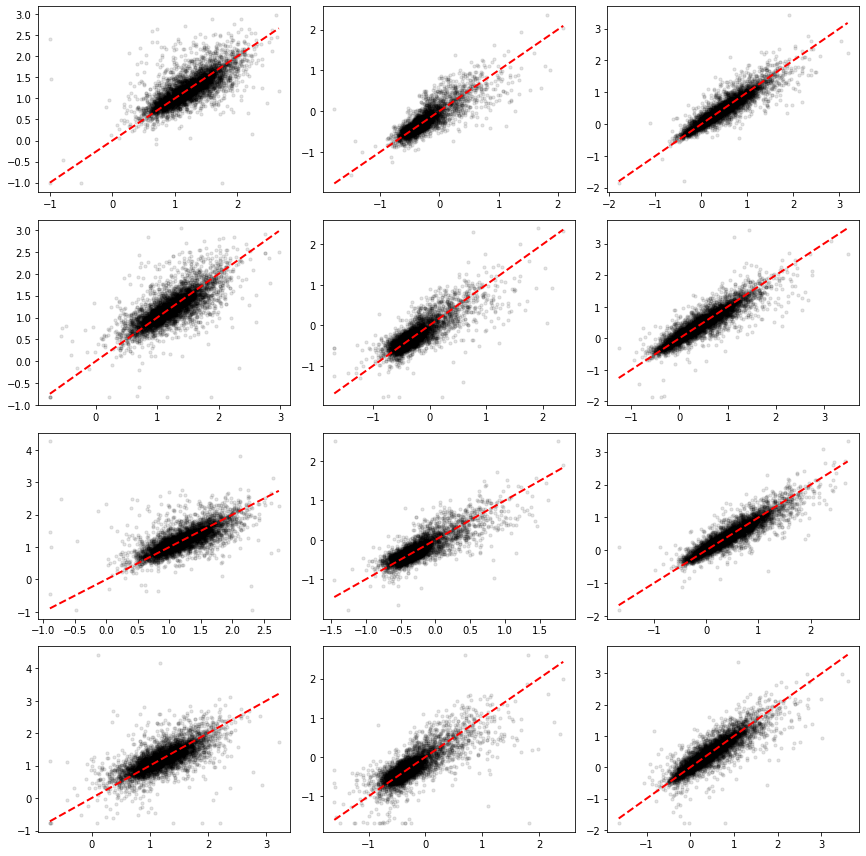

In [132]:
fig1,ax1 = plt.subplots(4,3,figsize=(12,12))
for d in range(n_datasets):
    for k in range(3):
        x=par_vals[d,0,:,k]
        y=par_vals[d,1,:,k]
        xl = [min(x),max(x)]
        ax1[d,k].scatter(x,y,10,'k',alpha=0.1) 

        ax1[d,k].plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()


In [201]:
dataset_names

NameError: name 'dataset_names' is not defined

In [133]:
n_genes = par_vals.shape[2]


In [134]:
p_par = np.zeros((n_genes,3))
for k in range(3):
    for j in range(n_genes):
        p_par[j,k] = scipy.stats.ttest_ind(par_vals[gf[:,0,j],0,j,k],par_vals[gf[:,1,j],1,j,k],equal_var=False)[1]


/tmp/ipykernel_2097544/2868503142.py:4: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  p_par[j,k] = scipy.stats.ttest_ind(par_vals[gf[:,0,j],0,j,k],par_vals[gf[:,1,j],1,j,k],equal_var=False)[1]


In [135]:
fc_par = ((par_vals[:,1,:,:]-par_vals[:,0,:,:])/np.log10(2)).mean(0)


In [202]:
allen_celltypes

[['allen_B08_Glutamatergic', 'allen_B08_GABAergic'],
 ['allen_C01_Glutamatergic', 'allen_C01_GABAergic'],
 ['allen_F08_Glutamatergic', 'allen_F08_GABAergic'],
 ['allen_H12_Glutamatergic', 'allen_H12_GABAergic']]

['Rnf152' '2010300C02Rik' 'Pip5k1c' 'Nin' 'Rap2a' 'Fzd3' 'Nr4a1' 'Dnajc21'
 'Igsf21' 'Rasgef1a' 'Igf1r' 'Stx4a' 'Rnf169' 'Mast3' 'Nectin1' 'Scg3'
 'Mras']
['Erbin' 'Mblac2' 'Mtss1' 'Arhgap12' 'Vav2' 'A530058N18Rik' 'Rcan3'
 'Ankrd6' 'Adcyap1r1' 'Crtc3' 'Egln1' 'Arpp19' 'Mid2']
['A330023F24Rik' 'Cacng5' 'Slc39a11' 'Erbin' 'B3galt5' 'Svil' 'Arhgap12'
 'Cxxc4' 'Ccdc136' 'Ank1' 'Amotl1' 'Mid2']


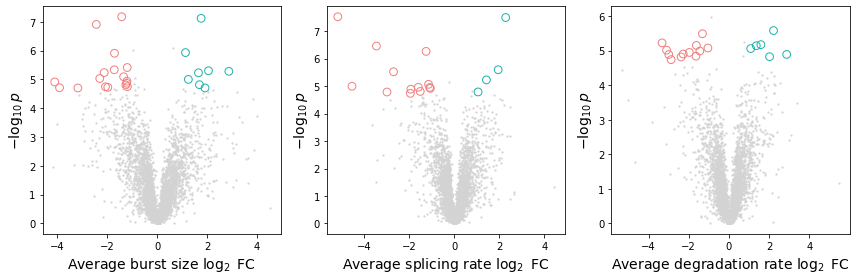

In [139]:
fig1,ax1 = plt.subplots(1,3,figsize=(12,4))
dr_par_multi = np.zeros((n_genes,3),dtype=bool)
pval_thr = 0.1/n_genes
gf_gaba_all = []
gf_glu_all = []
for k in range(3):
    fc_d = fc_par[:,k]
    gf_pval = p_par[:,k]<pval_thr
    
    gf_fc_gaba = fc_d>1
    gf_fc_glu = fc_d<-1
    gf_gaba = gf_pval & gf_fc_gaba
    gf_glu = gf_pval & gf_fc_glu
    
    gf_gaba_all.append(gf_gaba)
    gf_glu_all.append(gf_glu)
    
#     dr_par_multi[:,k] = gf
    gf_notselected = (~ gf_gaba) & (~ gf_glu)
    print(gn[gf_glu])
    logp_par = -np.log10(p_par[:,k])
    ax1[k].scatter(fc_d[gf_gaba],logp_par[gf_gaba],color=aesthetics['celltype_colors_allen'][1],
                   s=aesthetics['celltype_marker_ms'],
                   alpha=1,facecolors='none')
    ax1[k].scatter(fc_d[gf_glu],logp_par[gf_glu],color=aesthetics['celltype_colors_allen'][0],
                   s=aesthetics['celltype_marker_ms'],
                   alpha=1,facecolors='none')
    ax1[k].scatter(fc_d[gf_notselected],logp_par[gf_notselected],color=aesthetics['omitted_color'],\
                   s=aesthetics['omitted_markersize_body'],alpha=0.8)
    ax1[k].set_ylabel(r'$-\log_{10} p$',fontsize=aesthetics['fontsize_body_axes'])
    ax1[k].set_xlabel('Average ' + param_names[k].lower()+' $\log_2$ FC',fontsize=aesthetics['fontsize_body_axes'])
fig1.tight_layout()
# fig1.savefig('./'+figdir+'/volcano.png',dpi=600)


We have now reproduced Fig. 4d of "Length Biases." Now, let's focus on the genes that *also* have a low average log fold change...

In [140]:
log2_fc_spliced = np.zeros((n_genes,len(allen_celltypes)))
for k,celltype_datasets in enumerate(allen_celltypes):
    sd_arr_allen = [monod.analysis.load_search_data('/home/ggorin/projects/GP_2021_3/notebooks/fits/'+allen_celltype_batch_dir+'/'+x+'/raw.sd') for x in celltype_datasets]
    log2_fc_spliced[:,k] = np.log2(sd_arr_allen[1].layers[1].mean(1)/sd_arr_allen[0].layers[1].mean(1))
mean_log2_fc_spliced = log2_fc_spliced.mean(1)


/tmp/ipykernel_2097544/973810421.py:4: RuntimeWarning: divide by zero encountered in log2
  log2_fc_spliced[:,k] = np.log2(sd_arr_allen[1].layers[1].mean(1)/sd_arr_allen[0].layers[1].mean(1))


In [141]:
spliced_fc_gf = (np.abs(mean_log2_fc_spliced)<1)

In [316]:
# aesthetics['celltype_colors_allen']

In [143]:
logp_par = -np.log10(p_par)

Next, let's define an "aggregated" version of fold change parameters. We use the negative average of splicing rate and degradation rate change to estimate the burst frequency change.

In [219]:
deltaB = fc_par[:,0]
deltaK = -(fc_par[:,1]+fc_par[:,2])/2


In [220]:
gn = sr_arr_allen[0].gene_names

In [222]:
gf_glu_all = np.asarray(gf_glu_all)
gf_gaba_all = np.asarray(gf_gaba_all)

In [223]:
gf_gaba_all.shape

(3, 5000)

# Fig 5a

Noise enhancement = higher burst size, lower burst frequency.

In [406]:
c_genes = 'dimgrey'
alpha_genes = 0.1
c_highlight = 'tomato'
alpha_highlight = 0.7
c_baseline = np.asarray([9,160,115])/255
c_singlegene = 'dodgerblue'
ms_genes = 20
ms_highlight = 50
fs_axes = 12
fs_title=14
alpha_line = 0.48
lw = 3
c_baseline_violation = 'blueviolet'
c_identity = 'k'


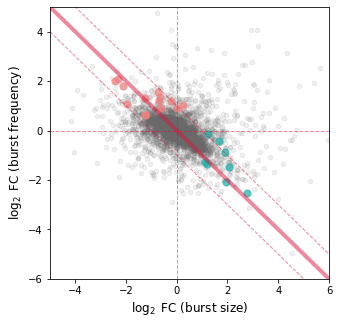

In [323]:
plt.figure(figsize=(5,5))
plt.scatter(deltaB,deltaK,ms_genes,c_genes,alpha=alpha_genes)
gf_glu_noise = (gf_glu_all[0] | gf_glu_all[1] | gf_glu_all[2])  & spliced_fc_gf 
plt.scatter(deltaB[gf_glu_noise],deltaK[gf_glu_noise],ms_highlight,aesthetics['celltype_colors_allen'][0],alpha=alpha_highlight)
gf_gaba_noise = (gf_gaba_all[0] | gf_gaba_all[1] | gf_gaba_all[2])  & spliced_fc_gf 
plt.scatter(deltaB[gf_gaba_noise],deltaK[gf_gaba_noise],ms_highlight,aesthetics['celltype_colors_allen'][1],alpha=alpha_highlight)
# gf = gf_glu_all[1] & spliced_fc_gf 
# plt.scatter(deltaB[gf],deltaK[gf],20,aesthetics['celltype_colors_allen'][0],alpha=1)
# gf = gf_gaba_all[0] & spliced_fc_gf 
# plt.scatter(deltaB[gf],deltaK[gf],20,aesthetics['celltype_colors_allen'][1],alpha=1)
# gf = gf_gaba_all[1] & spliced_fc_gf 
# plt.scatter(deltaB[gf],deltaK[gf],20,aesthetics['celltype_colors_allen'][1],alpha=1)
# plt.scatter(deltaB[gf_glu],deltaK[gf_glu],20,aesthetics['celltype_colors_allen'][0],alpha=1)
# plt.scatter(deltaB[gf_gaba],deltaK[gf_gaba],20,aesthetics['celltype_colors_allen'][1],alpha=1)
xl =np.asarray([-5,6])
xlx = [xl[0],xl[1]]
xly = [-xl[1],-xl[0]]
plt.xlim(xlx)
plt.ylim(xly)
plt.plot(xl,-xl,'-',linewidth=4,c='crimson',alpha=0.5)
plt.plot(xl,-(xl+1),'--',linewidth=1,c='crimson',alpha=0.5)
plt.plot(xl,-(xl-1),'--',linewidth=1,c='crimson',alpha=0.5)
# plt.plot(xlx,[1,1],'-',linewidth=1,c='crimson',alpha=0.5)
# plt.plot([1,1],xly,'-',linewidth=1,c='crimson',alpha=0.5)
# plt.plot(xlx,[-1,-1],'-',linewidth=1,c='crimson',alpha=0.5)
# plt.plot([-1,-1],xly,'-',linewidth=1,c='crimson',alpha=0.5)
plt.plot(xlx,[0,0],'--',linewidth=1,c='crimson',alpha=0.5)
plt.plot([0,0],xly,'--',linewidth=1,c='crimson',alpha=0.5)
plt.xlabel(r'$\log_2$ FC (burst size)',fontsize=fs_axes)
plt.ylabel(r'$\log_2$ FC (burst frequency)',fontsize=fs_axes)
plt.savefig('./figs/fig5a.png',dpi=450)
plt.savefig('./figs/fig5a.pdf')

# Fig 5b

In [324]:
# sr_arr_allen

In [325]:
dataset_ind = 0
sd_arr_allen = [monod.analysis.load_search_data('/home/ggorin/projects/GP_2021_3/notebooks/fits/'+allen_celltype_batch_dir+'/'+x+'/raw.sd') for x in allen_celltypes[dataset_ind]]
sr_arr_allen = [monod.analysis.load_search_results('/home/ggorin/projects/GP_2021_3/notebooks/fits/'+allen_celltype_batch_dir+'/'+x+'/Bursty_Poisson_1x1/grid_scan_results_upd.res') for x in allen_celltypes[dataset_ind]]


In [326]:
aesthetics['celltype_colors_allen']

('lightcoral', 'lightseagreen')

In [327]:
gf_glu_noise.sum()

14

In [328]:
inds_gaba = np.where((gf_gaba_noise & (gf_rej[0,:,:].all(0))))[0]
print(gn[inds_gaba])

['Fam174a' 'Socs2' 'Ankrd40' 'Rgmb' 'Dpysl3' 'Itga4' 'Bach2']


In [329]:
inds_glu = np.where((gf_glu_noise & (gf_rej[0,:,:].all(0))))[0]
print(gn[inds_glu])

['Rnf152' 'A330023F24Rik' 'Slc39a11' 'Nin' 'Mblac2' 'Cxxc4' 'Ankrd6'
 'Ccdc136' 'Stx4a' 'Crtc3' 'Egln1' 'Scg3' 'Mid2']


In [330]:
par_vals_uncorrected.shape

(4, 2, 5000, 3)

Nin
[5.98450047 1.69262372]
[3.27098321 0.97961631]
Bach2
[5.74920635 0.86984127]
[12.07434053  1.3501199 ]


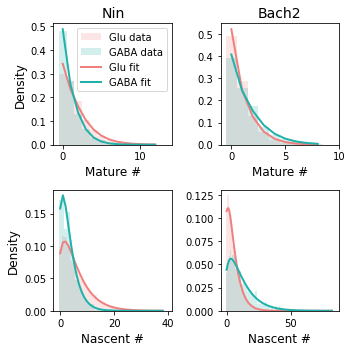

In [331]:
fig1,ax1 = plt.subplots(2,2,figsize=(5,5))
l_=1
for gene_ind,k_ in enumerate([3,6]):
    if gene_ind ==0:
        global_ind = inds_glu[k_]
    else:
        global_ind = inds_gaba[k_]
        
    glu_data = sd_arr_allen[0].layers[:,global_ind,:]
    gaba_data = sd_arr_allen[1].layers[:,global_ind,:]
    print(gn[global_ind])
    print(glu_data.mean(-1))
    print(gaba_data.mean(-1))
#     else:
#         glu_data = sd_arr_allen[0].layers[:,inds_gaba[k_],:]
#         gaba_data = sd_arr_allen[1].layers[:,inds_gaba[k_],:]
#         print(gn[inds_gaba[k_]])
        
    bins_mat = np.arange(max(glu_data[1].max(),gaba_data[1].max())+1)-0.5
    ax1[0,gene_ind].hist(glu_data[1],bins_mat,density=True,alpha=0.2,facecolor=aesthetics['celltype_colors_allen'][0],
                                                       label='Glu data')
    ax1[0,gene_ind].hist(gaba_data[1],bins_mat,density=True,alpha=0.2,facecolor=aesthetics['celltype_colors_allen'][1],
                                                       label='GABA data')
    bins_nas = np.arange(max(glu_data[0].max(),gaba_data[0].max())+1)-0.5
    ax1[1,gene_ind].hist(glu_data[0],bins_nas,density=True,alpha=0.2,facecolor=aesthetics['celltype_colors_allen'][0])
    ax1[1,gene_ind].hist(gaba_data[0],bins_nas,density=True,alpha=0.2,facecolor=aesthetics['celltype_colors_allen'][1])
    
    pars_glu = par_vals_uncorrected[dataset_ind,0,global_ind,:]
    pars_gaba = par_vals_uncorrected[dataset_ind,1,global_ind,:]
    ########
    mx = int(bins_mat[-1]+10)    
    mx_ = int(bins_mat[-1])
    pmf_glu_mat = sr_arr_allen[0].model.eval_model_pss(pars_glu,[1,mx],sr_arr_allen[0].regressor_optimum[global_ind])
    ax1[0,gene_ind].plot(np.arange(mx_),pmf_glu_mat[:mx_],color=aesthetics['celltype_colors_allen'][0],linewidth=2,label='Glu fit')
    pmf_gaba_mat = sr_arr_allen[1].model.eval_model_pss(pars_gaba,[1,mx],sr_arr_allen[1].regressor_optimum[global_ind])
    ax1[0,gene_ind].plot(np.arange(mx_),pmf_gaba_mat[:mx_],color=aesthetics['celltype_colors_allen'][1],linewidth=2,label='GABA fit')
    ##########
    mx = int(bins_nas[-1]+10)    
    mx_ = int(bins_nas[-1])
    pmf_glu_nas = sr_arr_allen[0].model.eval_model_pss(pars_glu,[mx,1],sr_arr_allen[0].regressor_optimum[global_ind])
    ax1[1,gene_ind].plot(np.arange(mx_),pmf_glu_nas[:mx_],color=aesthetics['celltype_colors_allen'][0],linewidth=2)
    pmf_gaba_nas = sr_arr_allen[1].model.eval_model_pss(pars_gaba,[mx,1],sr_arr_allen[1].regressor_optimum[global_ind])
    ax1[1,gene_ind].plot(np.arange(mx_),pmf_gaba_nas[:mx_],color=aesthetics['celltype_colors_allen'][1],linewidth=2)
    ax1[0,gene_ind].set_xlabel('Mature #',fontsize=fs_axes)
    ax1[1,gene_ind].set_xlabel('Nascent #',fontsize=fs_axes)
    ax1[0,gene_ind].set_title(gn[global_ind],fontsize=fs_title)
ax1[0,0].legend()
ax1[0,0].set_ylabel('Density',fontsize=fs_axes)
ax1[1,0].set_ylabel('Density',fontsize=fs_axes)
    
#     print(glu_data.mean())
#     print(gaba_data.mean())
fig1.tight_layout()
plt.savefig('./figs/fig5b.png',dpi=450)
plt.savefig('./figs/fig5b.pdf')

# Fig 5c

In [546]:
dataset_meta = ['desai_dmso','desai_idu']
dataset_names = dataset_meta 
dir_string = './fits/gg_230329_026_desai_1'
result_strings = [dir_string + '/'+x+'/Bursty_Poisson_20x21/grid_scan_results_upd.res' for x in dataset_names]

In [547]:
sr_arr = [monod.analysis.load_search_results(x) for x in result_strings]
sd_arr = [monod.analysis.load_search_data(dir_string+'/'+x+'/raw.sd') for x in dataset_names]

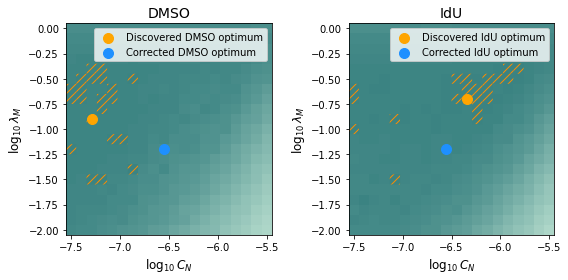

In [548]:
from matplotlib.colors import ListedColormap

c1 = [173/255,214/255,200/255]
c2 = [59/255,131/255,130/255]
ncol=50
cmap_histogram = ListedColormap(np.array([np.linspace(c2[j],c1[j],ncol) for j in range(3)]).T)

def plot_landscape(sr,ax):
    x_ = np.unique(sr.sp.X)
    y_ = np.unique(sr.sp.Y)
    nX = len(x_)
    nY = len(y_)
    X,Y = np.meshgrid(x_,y_,indexing='ij')
    kld = np.reshape(np.log10(sr.klds.sum(1)),sr.sp.gridsize)
#     print(kld)
    vmin = kld.min()
    vmax = kld.max()
    ax.pcolormesh(X,Y,(kld),cmap=cmap_histogram,vmin=vmin,vmax=vmax)
    q = np.quantile(kld,0.05)
    ax.pcolor(X,Y,np.ma.masked_array(kld,kld>q),
                  cmap=cmap_histogram,
                  alpha=1,hatch='///',edgecolor='darkorange',facecolor=None,linewidth=0,
                  vmin=vmin,vmax=vmax)

    #     print(kld.shape)
#     print(X.shape)
    # logL_2d = np.zeros((nX,nY))
# fs=12
fig1,ax1= plt.subplots(1,2,figsize=(8,4))
names = ['DMSO','IdU']
abbr_names = names
# arbitrary_v3_params = np.asarray(sr_arr[0].samp_optimum)+0.5
# arbitrary_v3_ind = np.argmin(((sr_arr[1].param_estimates[:,~sr_arr[0].rejected_genes,:] - sr_arr[0].phys_optimum[~sr_arr[0].rejected_genes])**2)[:,:,:2].sum((1,2)))
arbitrary_v2_params = np.asarray([-6.5,-1.2])
arbitrary_v2_ind = np.argmin(((sr_arr[1].sp.sampl_vals-arbitrary_v2_params)**2).sum(1))
arbitrary_v2_pars = sr_arr[1].sp.sampl_vals[arbitrary_v2_ind]
for k in range(2):
    plot_landscape(sr_arr[k],ax1[k])
    ax1[k].scatter(sr_arr[k].samp_optimum[0],sr_arr[k].samp_optimum[1],100,c='orange',label='Discovered {} optimum'.format(abbr_names[k]))
    ax1[k].scatter(arbitrary_v2_pars[0],arbitrary_v2_pars[1],100,c='dodgerblue',label='Corrected {} optimum'.format(abbr_names[k]))
    ax1[k].set_xlabel(r'$\log_{10} C_N$',fontsize=fs_axes)
    ax1[k].set_ylabel(r'$\log_{10} \lambda_M$',fontsize=fs_axes)
    ax1[k].set_title(names[k],fontsize=fs_title)
    ax1[k].legend(loc='upper right')
fig1.tight_layout()
plt.savefig('./figs/desai_landscape.png',dpi=450)
plt.savefig('./figs/desai_landscape.pdf')


In [549]:
sr_arr[k].samp_optimum[0]

-6.342105263157895

In [550]:
# sr_arr[0].samp_optimum

In [551]:
for k in range(2):
    sr_arr[k].set_sampling_optimum(arbitrary_v2_ind)
    _=sr_arr[k].chisquare_testing(sd_arr[k],threshold=0.01)

# sr_arr[0].set_sampling_optimum(arbitrary_v2_ind)
# sr_arr

dmso: -6.55, -1.20
idu: -6.55, -1.20


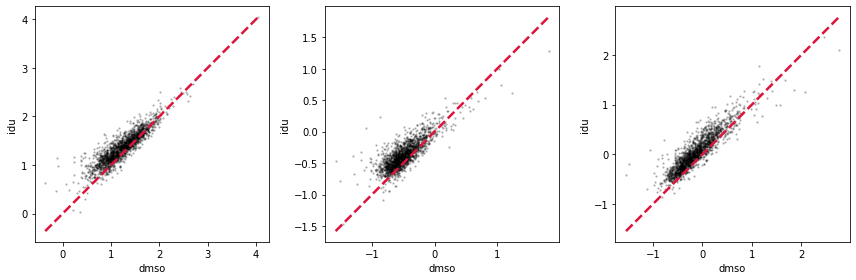

In [552]:
fig1,ax1 = plt.subplots(1,3,figsize=(12,4))

print('dmso: {:.2f}, {:.2f}'.format(*sr_arr[0].samp_optimum))

print('idu: {:.2f}, {:.2f}'.format(*sr_arr[1].samp_optimum))
gf_rej = (~sr_arr[1].rejected_genes)&(~sr_arr[0].rejected_genes)
for j in range(3):
    x = sr_arr[0].phys_optimum[gf_rej,j]
    y = sr_arr[1].phys_optimum[gf_rej,j]
    ax1[j].scatter(x,y,2,'k',alpha=0.2)
    xl = np.linspace(min(x),max(x))
    ax1[j].plot(xl,xl,'--',color='crimson',linewidth=2.5)
    ax1[j].set_xlabel('dmso')
    ax1[j].set_ylabel('idu')
fig1.tight_layout()

In [553]:
par_vals = np.asarray([sr_arr[0].phys_optimum,sr_arr[1].phys_optimum])

In [554]:
fc_par = ((par_vals[1,:,:]-par_vals[0,:,:])/np.log10(2))

In [555]:
deltaB = fc_par[:,0]
deltaK = -(fc_par[:,1]+fc_par[:,2])/2

In [556]:
markers = ['Nanog','Sox2', 'Pou5f1','Klf4','Wdr83','Stx7','Hif1an','Mtpap','Farsa','Wipi2','Snd1']

In [557]:
gn = sr_arr[0].gene_names

In [558]:
marker_inds = [np.where(gn==mk)[0][0] for mk in markers]

In [560]:
gf_rej[marker_inds]

array([False,  True, False, False,  True,  True,  True,  True,  True,
        True,  True])

In [561]:
for i,mi in enumerate(marker_inds):
    print('{}. Rejected: {}. Mean in DMSO: {:.2f}. Mean in IdU: {:.2f}.\n\tBurst size fc: {:2f}.\n\tBurst freq fc: {:.2f}.'.format(
        markers[i],~gf_rej[mi],sd_arr[0].layers[1,mi,:].mean(),sd_arr[1].layers[1,mi,:].mean(),\
        deltaB[mi],deltaK[mi]))

Nanog. Rejected: True. Mean in DMSO: 13.46. Mean in IdU: 8.51.
	Burst size fc: 0.532120.
	Burst freq fc: -1.22.
Sox2. Rejected: False. Mean in DMSO: 0.00. Mean in IdU: 0.00.
	Burst size fc: 0.000000.
	Burst freq fc: -0.00.
Pou5f1. Rejected: True. Mean in DMSO: 10.30. Mean in IdU: 8.42.
	Burst size fc: -9.216237.
	Burst freq fc: 5.28.
Klf4. Rejected: True. Mean in DMSO: 13.44. Mean in IdU: 9.90.
	Burst size fc: 10.054566.
	Burst freq fc: -7.01.
Wdr83. Rejected: False. Mean in DMSO: 2.59. Mean in IdU: 1.94.
	Burst size fc: -0.089273.
	Burst freq fc: -0.17.
Stx7. Rejected: False. Mean in DMSO: 1.47. Mean in IdU: 1.41.
	Burst size fc: 4.237180.
	Burst freq fc: -4.07.
Hif1an. Rejected: False. Mean in DMSO: 0.44. Mean in IdU: 0.32.
	Burst size fc: -1.126197.
	Burst freq fc: 0.77.
Mtpap. Rejected: False. Mean in DMSO: 1.87. Mean in IdU: 1.58.
	Burst size fc: 1.272200.
	Burst freq fc: -1.54.
Farsa. Rejected: False. Mean in DMSO: 7.44. Mean in IdU: 6.07.
	Burst size fc: 0.365224.
	Burst freq fc

In [562]:
c_genes = 'dimgrey'
alpha_genes = 0.1
c_highlight = 'tomato'
alpha_highlight = 0.7
c_baseline = np.asarray([9,160,115])/255
c_singlegene = 'dodgerblue'
ms_genes = 20
ms_highlight = 50
fs_axes = 12
fs_title=14
alpha_line = 0.48
lw = 3
c_baseline_violation = 'blueviolet'
c_identity = 'k'


In [563]:
thrpars = 1.5
thrmean = 1
gf_highnoise = (np.abs(deltaB)>thrpars) & (np.abs(deltaK)>thrpars)  \
    & ((sd_arr[1].layers[1].mean(1)>thrmean) | (sd_arr[0].layers[1].mean(1)>thrmean)) \
    & gf_rej

In [564]:
gf_highnoise.sum()

11

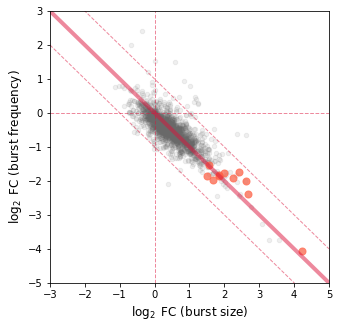

In [565]:
plt.figure(figsize=(5,5))
plt.scatter(deltaB[gf_rej],deltaK[gf_rej],ms_genes,c_genes,alpha=alpha_genes)
plt.scatter(deltaB[gf_highnoise],deltaK[gf_highnoise],ms_highlight,c_highlight,alpha=alpha_highlight)
xl =np.asarray([-3,5])
xlx = [xl[0],xl[1]]
xly = [-xl[1],-xl[0]]
plt.xlim(xlx)
plt.ylim(xly)
plt.plot(xl,-xl,'-',linewidth=4,c='crimson',alpha=0.5)
plt.plot(xl,-(xl+1),'--',linewidth=1,c='crimson',alpha=0.5)
plt.plot(xl,-(xl-1),'--',linewidth=1,c='crimson',alpha=0.5)
plt.plot(xlx,[0,0],'--',linewidth=1,c='crimson',alpha=0.5)
plt.plot([0,0],xly,'--',linewidth=1,c='crimson',alpha=0.5)
plt.xlabel(r'$\log_2$ FC (burst size)',fontsize=fs_axes)
plt.ylabel(r'$\log_2$ FC (burst frequency)',fontsize=fs_axes)
plt.savefig('./figs/fig5c.png',dpi=450)
plt.savefig('./figs/fig5c.pdf')

In [566]:
gn = sr_arr[0].gene_names

In [567]:
for x in gn[gf_highnoise]:
    print(x)

Stx7
Washc5
Apod
Eif2ak2
Ubr2
Cnnm2
Dram2
Zfp110
Cul4a
Ddx19b
Yap1
